# 2. 短命作品の学習と予測

　目次情報を学習して，短命作品を予測してみます．

## 環境構築

```bash
conda env create -f env.yml
source activate comic
```

## 目次データ

　[0_obtain_comic_data_j.ipynb](0_obtain_comic_data_j.ipynb)で取得した`data/wj-api.json`を使います．また，[1_analyze_comic_data_j.ipynb](1_analyze_comic_data_j.ipynb)で定義した`ComicAnalyzer`を`comic.py`からimportして使います．

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
import comic

wj = comic.ComicAnalyzer()

## 問題設定

　本記事では，以下の入力をもとに，短命作品か否かを分類する問題に挑戦します．

### 入力

　入力として，連載開始7週目までの各週掲載順と合計カラー回数の，計8次元の情報を用います．7週目までのデータを用いるのは，近年の最短連載（8週間）の，遅くとも一週間に打ち切りを予測したいと考えたためです．掲載順だけでなくカラー回数を用いるのは，予測精度を上げるためです．直感的には，人気作品ほど，カラー回数が多い傾向があります．

### 短命作品

　[前編](http://qiita.com/haltaro/items/c54fa1855767f1a1abd5)では，「短命作品」を以下のように定義しました．
 
 > 本記事では，機械学習を使って，短命作品（10週以内に終了する作品）の予測を行います．
 
しかし，改めて`wj-api.json`を分析すると，10週以内に終了する作品が極めて少ないことがわかります．

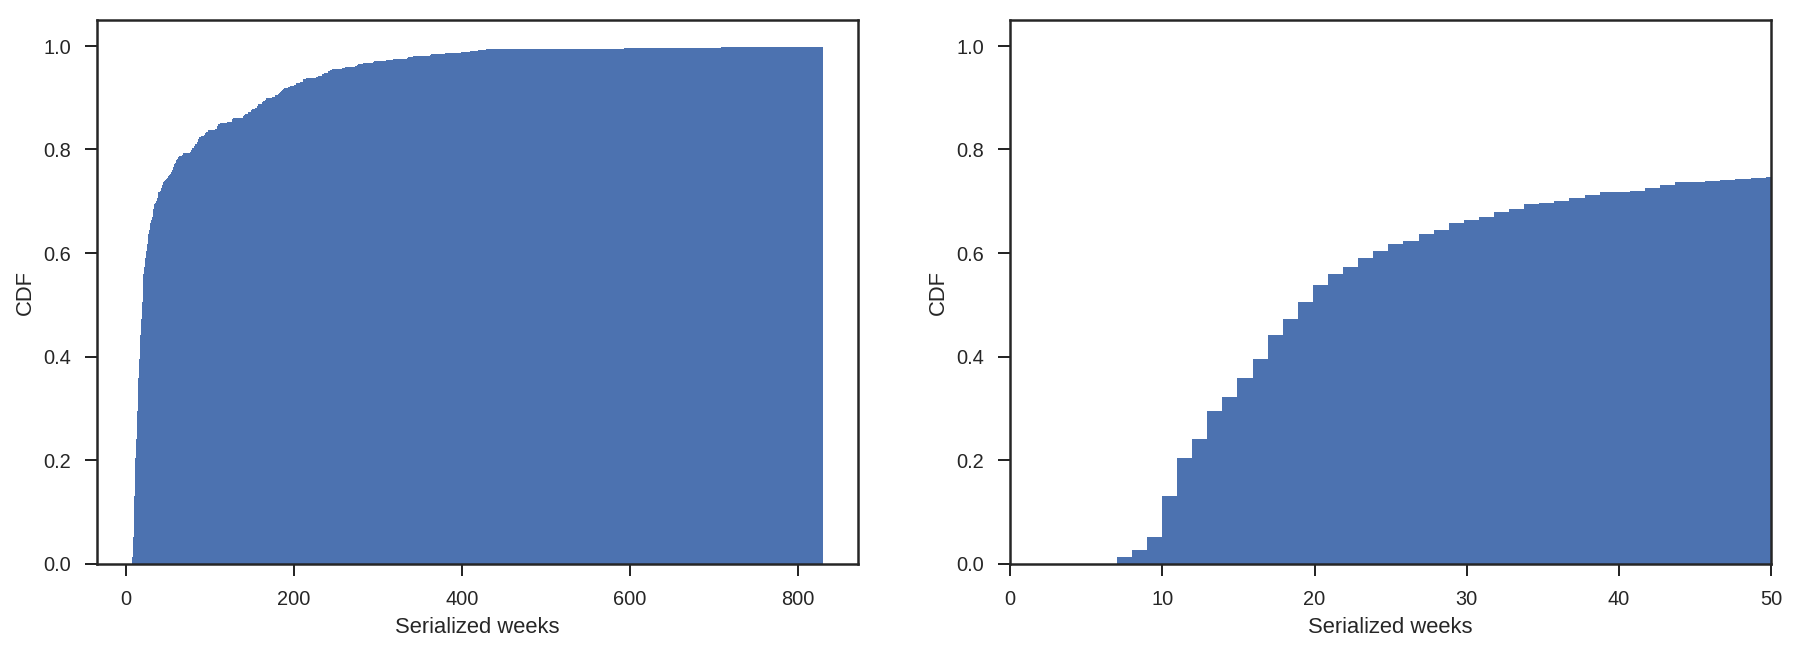

In [3]:
weeks = [len(wj.extract_item(title))
         for title in wj.end_titles]

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
_ = plt.hist(weeks, normed=True, cumulative=True, bins=max(weeks))
plt.xlabel('Serialized weeks')
plt.ylabel('CDF')

plt.subplot(1, 2, 2)
_ = plt.hist(weeks, normed=True, cumulative=True, bins=max(weeks))
plt.xlim(0, 50)
plt.xlabel('Serialized weeks')
plt.ylabel('CDF')

左図は全作品の累積分布であり，右図は左図の50週までに注目したものです．横軸は掲載期間，縦軸は強度です．右図から，10週までに終了した作品は10%以下であることがわかります．

　[Applying deep learning to real-world problems - Merantix](https://medium.com/merantix/applying-deep-learning-to-real-world-problems-ba2d86ac5837)によると，データラベルに偏りがある場合の対処法の一つとして，ラベリングの変更が提案されています．そこで本記事では，便宜上，短命作品の定義を**20週以内に終了した作品**に変更します（10週以内に終了した作品の予測については，今後の宿題とさせてください…）．閾値を20週にすると，約半数の作品を短命作品として扱えます．

## モデル

### 多層パーセプトロン

　以下は，本記事で扱う[多層パーセプトロン](https://en.wikipedia.org/wiki/Multilayer_perceptron)のモデルです．多層パーセプトロンついては，[誤差逆伝播法のノート](http://qiita.com/Ugo-Nama/items/04814a13c9ea84978a4c)が詳しいです．

![model](fig/model.png)

隠れ層は7ノード2層です．隠れ層の活性化関数として，[ReLU](https://ja.wikipedia.org/wiki/%E6%B4%BB%E6%80%A7%E5%8C%96%E9%96%A2%E6%95%B0#ReLU.EF.BC.88.E3.83.A9.E3.83.B3.E3.83.97.E9.96.A2.E6.95.B0.EF.BC.89)を使います．出力層は短命作品である確率を出力し，活性化関数として[Sigmoid](https://ja.wikipedia.org/wiki/%E6%B4%BB%E6%80%A7%E5%8C%96%E9%96%A2%E6%95%B0#.E3.82.B7.E3.82.B0.E3.83.A2.E3.82.A4.E3.83.89.E9.96.A2.E6.95.B0)を使います．学習には，[Adam](https://arxiv.org/abs/1412.6980)を使います．学習率$r$は，[TensorBoard](https://www.tensorflow.org/get_started/summaries_and_tensorboard)でチューニングします．

### Dataset

　本記事では，短命作品273作品，継続作品273作品の合計546作品を用います．新しい作品から順に100作品をtestデータ，100作品をvalidationデータ，346作品をtrainingデータとして用います．testデータは最終評価のためのデータ，validation用データはハイパーパラメータ（$r$）調整のためのデータ，trainingデータは学習のためのデータです．これらについては，[なぜ教師あり学習でバリデーションセットとテストセットを分ける必要があるのか？](http://qiita.com/QUANON/items/ae569961ea02b4468e23)がわかりやすいです．

　本記事では，以下３種類の異なる方法で，trainingデータを利用します．`x_test`および`y_test`はtestデータ，`x_val`および`y_val`はvalidationデータ，`x_tra`および`y_tra`はtrainingデータを表します．
 
 ![data](fig/data.png)
 
　Dataset 1では，trainingデータ346作品を全て学習に利用します．Dataset 2では，trainingデータのうち約半分の古い作品を除外して，学習に利用します．これは，trainingデータの一部の作品は古すぎて，現在のジャンプ編集部の打ち切り方針の学習に適さない（ノイズとなる）と考えたためです．Dataset 3では，Dataset 2をdataset augmentationにより水増しし，学習に利用します．これは，Dataset 2では学習データが少なすぎて，十分な汎化性能が得られないと考えたためです．
 
　Dataset augmentationは，データを加工してtrainingデータを水増しするテクニックです．主に画像認識や音声認識の性能向上に効果があることが知られています．詳細は，[Deep learning bookの7.4節](http://www.deeplearningbook.org/contents/regularization.html)や，[機械学習のデータセット画像枚数を増やす方法](http://qiita.com/bohemian916/items/9630661cd5292240f8c7)をご参照ください．本記事の裏テーマは，週刊漫画雑誌の打ち切り予測におけるDataset augmentationの有効性を評価することです．当たり前ですが前例がありませんので，どのようにデータを水増しするか考える必要があります．本記事では，下図のような方法でData augmentationを行います．
 
 ![aug](fig/aug.png)

　ざっくり言うと，同じラベルのデータをランダムに２つ選択し，それらのランダムな重み付き平均をとることで，新しいデータを生成します．この背後には，複数の短命作品の中間的な成績（掲載順）を持つ作品も，やはり短命作品だろうという仮定があります．直感的には，そんなに悪くない仮定に思えます．

## 実装

　多層パーセプトロンを管理するためのクラス`ComicNet()`を以下に定義します．`ComicNet()`は，各種データ（学習，検証，およびテスト）の生成，多層パーセプトロンの構築，学習，およびテストを実行できます．実装には，[TensorFlow](https://www.tensorflow.org/)を用います．[TensorFlow](https://www.tensorflow.org/)については，[特にプログラマーでもデータサイエンティストでもないけど、Tensorflowを1ヶ月触ったので超分かりやすく解説](http://qiita.com/tawago/items/c977c79b76c5979874e8)が詳しいです．

In [4]:
class ComicNet():
    """ マンガ作品が短命か否かを識別する多層パーセプトロンを管理するクラスです．  
    :param analyzer：ComicAnalyzerクラスのオブジェクト．
    :param n_drop:学習用データから除外するデータ数
    :param n_aug:学習用データに追加する人工データ数
    :param thresh_week：短命作品とそれ以外を分けるしきい値．
    :param n_x：多層パーセプトロンに入力する掲載週の数．入力層のノード数．
    """
    def __init__(self, thresh_week=20, n_x=7):
        self.n_x = n_x
        self.thresh_week = thresh_week        
    
    def get_x(self, analyzer, title):
        """指定された作品の指定週までの正規化掲載順を取得する関数です．"""
        worsts = np.array(analyzer.extract_item(title)[:self.n_x])
        bests = np.array(analyzer.extract_item(title, 'best')[:self.n_x])
        bests_normalized = bests / (worsts + bests - 1)
        color = sum(analyzer.extract_item(title, 'color')[:self.n_x]
                    ) /self.n_x
        return np.append(bests_normalized, color)

    def get_y(self, analyzer, title, thresh_week):
        """指定された作品が，短命作品か否かを取得する関数です．"""
        return int(len(analyzer.extract_item(title)) <=  thresh_week)

    def get_xs_ys(self, analyzer, titles, thresh_week):
        """指定された作品群の特徴量とラベルとタイトルを返す関数です．
        　　y==0とy==1のデータ数を揃えて返します．
        """
        xs = np.array([self.get_x(analyzer, title) for title in titles])
        ys = np.array([[self.get_y(analyzer, title, thresh_week)] 
                       for title in titles])
        
        # ys==0とys==1のデータ数を揃えます．
        idx_ps = np.where(ys.reshape((-1)) == 1)[0]
        idx_ng = np.where(ys.reshape((-1)) == 0)[0]
        len_data = min(len(idx_ps), len(idx_ng))
        x_ps = xs[idx_ps[-len_data:]]
        x_ng = xs[idx_ng[-len_data:]]
        y_ps = ys[idx_ps[-len_data:]]
        y_ng = ys[idx_ng[-len_data:]]
        t_ps = [titles[ii] for ii in idx_ps[-len_data:]]
        t_ng = [titles[ii] for ii in idx_ng[-len_data:]]
        
        return x_ps, x_ng, y_ps, y_ng, t_ps, t_ng
        
    def augment_x(self, x, n_aug):
        """指定された数のxデータを人為的に生成する関数です．"""
        if n_aug:
            x_pair = np.array(
                [[x[idx] for idx in 
                  np.random.choice(range(len(x)), 2, replace=False)]
                 for _ in range(n_aug)])
            weights = np.random.rand(n_aug, 1, self.n_x + 1)
            weights = np.concatenate((weights, 1 - weights), axis=1)
            x_aug = (x_pair * weights).sum(axis=1)
            
            return np.concatenate((x, x_aug), axis=0)
        else:
            return x
        
    def augment_y(self, y, n_aug):
        """指定された数のyデータを人為的に生成する関数です．"""
        if n_aug:
            y_aug = np.ones((n_aug, 1)) if y[0, 0] \
                else np.zeros((n_aug, 1))
            return np.concatenate((y, y_aug), axis=0)
        else:
            return y
        
    def configure_dataset(self, analyzer, n_drop=0, n_aug=0):
        """データセットを設定する関数です．
        :param analyzer: ComicAnalyzerクラスのインスタンス
        :param n_drop: trainingデータから除外する古いデータの数
        :param n_aug: trainingデータに追加するaugmentedデータの数
        """
        x_ps, x_ng, y_ps, y_ng, t_ps, t_ng = self.get_xs_ys(
            analyzer, analyzer.end_titles, self.thresh_week)
        self.x_test = np.concatenate((x_ps[-50:], x_ng[-50:]), axis=0)
        self.y_test = np.concatenate((y_ps[-50:], y_ng[-50:]), axis=0)
        self.titles_test = t_ps[-50:] + t_ng[-50:]
        self.x_val = np.concatenate((x_ps[-100 : -50], 
                                     x_ng[-100 : -50]), axis=0)
        self.y_val = np.concatenate((y_ps[-100 : -50], 
                                     y_ng[-100 : -50]), axis=0)
        self.x_tra = np.concatenate(
            (self.augment_x(x_ps[n_drop//2 : -100], n_aug//2), 
             self.augment_x(x_ng[n_drop//2 : -100], n_aug//2)), axis=0)
        self.y_tra = np.concatenate(
            (self.augment_y(y_ps[n_drop//2 : -100], n_aug//2), 
             self.augment_y(y_ng[n_drop//2 : -100], n_aug//2)), axis=0)
    
    def build_graph(self, r=0.001, n_h=7, stddev=0.01):
        """多層パーセプトロンを構築する関数です．
        :param r: 学習率
        :param n_h: 隠れ層のノード数
        :param stddev: 変数の初期分布の標準偏差
        """
        tf.reset_default_graph()
        
        # 入力層およびターゲット
        n_y = self.y_test.shape[1]
        self.x = tf.placeholder(tf.float32, [None, self.n_x + 1], name='x')
        self.y = tf.placeholder(tf.float32, [None, n_y], name='y')
        
        # 隠れ層（１層目）
        self.w_h_1 = tf.Variable(
            tf.truncated_normal((self.n_x + 1, n_h), stddev=stddev))
        self.b_h_1 = tf.Variable(tf.zeros(n_h))
        self.logits = tf.add(tf.matmul(self.x, self.w_h_1), self.b_h_1)
        self.logits = tf.nn.relu(self.logits)
        
        # 隠れ層（２層目）
        self.w_h_2 = tf.Variable(
            tf.truncated_normal((n_h, n_h), stddev=stddev))
        self.b_h_2 = tf.Variable(tf.zeros(n_h))
        self.logits = tf.add(tf.matmul(self.logits, self.w_h_2), self.b_h_2)
        self.logits = tf.nn.relu(self.logits)
        
        # 出力層
        self.w_y = tf.Variable(
            tf.truncated_normal((n_h, n_y), stddev=stddev))
        self.b_y = tf.Variable(tf.zeros(n_y))
        self.logits = tf.add(tf.matmul(self.logits, self.w_y), self.b_y)
        tf.summary.histogram('logits', self.logits)
        
        # 損失関数
        self.loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                logits=self.logits, labels=self.y))
        tf.summary.scalar('loss', self.loss)
        
        # 最適化
        self.optimizer = tf.train.AdamOptimizer(r).minimize(self.loss)
        self.output = tf.nn.sigmoid(self.logits, name='output')
        correct_prediction = tf.equal(self.y, tf.round(self.output))
        self.acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),
            name='acc')
        tf.summary.histogram('output', self.output)
        tf.summary.scalar('acc', self.acc)
        
        self.merged = tf.summary.merge_all()
            
        
    def train(self, epoch=2000, print_loss=False, save_log=False, 
              log_dir='./logs/1', log_name='', save_model=False,
              model_name='prediction_model'):
        """多層パーセプトロンを学習させ，ログや学習済みモデルを保存する関数です．
        :param epoch: エポック数
        :pram print_loss: 損失関数の履歴を出力するか否か
        :param save_log: ログを保存するか否か
        :param log_dir: ログの保存ディレクトリ
        :param log_name: ログの保存名
        :param save_model: 学習済みモデルを保存するか否か
        :param model_name: 学習済みモデルの保存名
        """
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer()) # 変数の初期化
            
            # ログ保存用の設定
            log_tra = log_dir + '/tra/' + log_name 
            writer_tra = tf.summary.FileWriter(log_tra)
            log_val = log_dir + '/val/' + log_name
            writer_val = tf.summary.FileWriter(log_val)        

            for e in range(epoch):
                feed_dict = {self.x: self.x_tra, self.y: self.y_tra}
                _, loss_tra, acc_tra, mer_tra = sess.run(
                        (self.optimizer, self.loss, self.acc, self.merged), 
                        feed_dict=feed_dict)
                
                # validation
                feed_dict = {self.x: self.x_val, self.y: self.y_val}
                loss_val, acc_val, mer_val = sess.run(
                    (self.loss, self.acc, self.merged),
                    feed_dict=feed_dict)
                
                # ログの保存
                if save_log:
                    writer_tra.add_summary(mer_tra, e)
                    writer_val.add_summary(mer_val, e)
                
                # 損失関数の出力
                if print_loss and e % 500 == 0:
                    print('# epoch {}: loss_tra = {}, loss_val = {}'.
                          format(e, str(loss_tra), str(loss_val)))
            
            # モデルの保存
            if save_model:
                saver = tf.train.Saver()
                _ = saver.save(sess, './models/' + model_name)
            
            
    def test(self, model_name='prediction_model'):
        """指定されたモデルを読み込み，テストする関数です．
        :param model_name: 読み込むモデルの名前
        """
        tf.reset_default_graph()
        loaded_graph = tf.Graph()
        
        with tf.Session(graph=loaded_graph) as sess:
            
            # モデルの読み込み
            loader = tf.train.import_meta_graph(
                './models/{}.meta'.format(model_name))
            loader.restore(sess, './models/' + model_name)
            
            x_loaded = loaded_graph.get_tensor_by_name('x:0')
            y_loaded = loaded_graph.get_tensor_by_name('y:0')
            
            loss_loaded = loaded_graph.get_tensor_by_name('loss:0')
            acc_loaded = loaded_graph.get_tensor_by_name('acc:0')
            output_loaded = loaded_graph.get_tensor_by_name('output:0')
        
            # test
            feed_dict = {x_loaded: self.x_test, y_loaded: self.y_test}
            loss_test, acc_test, output_test = sess.run(
                (loss_loaded, acc_loaded, output_loaded), feed_dict=feed_dict)
            return acc_test, output_test

## 実験
### ハイパーパラメータ（学習率r，epoch数）の調整
　　[TensorBoard](https://www.tensorflow.org/get_started/summaries_and_tensorboard)を使ってハイパーパラメータ（学習率$r$とepoch数）をチューニングします．いろいろ遊べますが，本記事では，validationデータのaccuracy（正解率）とloss（損失関数の出力）を可視化することで，ハイパーパラメータの調整を行います．TensorBoardの詳細は[公式](https://www.tensorflow.org/get_started/summaries_and_tensorboard)をご参照ください．

In [16]:
rs = [n * 10 ** m for m in range(-4, -1) for n in range(1, 10)]

In [17]:
datasets = [
    {'n_drop':0, 'n_aug':0},
    {'n_drop':173, 'n_aug':0},
    {'n_drop':173, 'n_aug':173},
]

In [21]:
wjnet = ComicNet()
for i, dataset in enumerate(datasets):
    wjnet.configure_dataset(wj, n_drop=dataset['n_drop'], 
                            n_aug=dataset['n_aug'])
    log_dir = './logs/dataset={}/'.format(i + 1)
    for r in rs:
        log_name = str(r)
        wjnet.build_graph(r=r)
        wjnet.train(epoch=20000, save_log=True, log_dir=log_dir, 
                log_name=log_name)
        print('Saved log of dataset={}, r={}'.format(i + 1, r))

Saved log of dataset=1, r=0.0001
Saved log of dataset=1, r=0.0002
Saved log of dataset=1, r=0.00030000000000000003
Saved log of dataset=1, r=0.0004
Saved log of dataset=1, r=0.0005
Saved log of dataset=1, r=0.0006000000000000001
Saved log of dataset=1, r=0.0007
Saved log of dataset=1, r=0.0008
Saved log of dataset=1, r=0.0009000000000000001
Saved log of dataset=1, r=0.001
Saved log of dataset=1, r=0.002
Saved log of dataset=1, r=0.003
Saved log of dataset=1, r=0.004
Saved log of dataset=1, r=0.005
Saved log of dataset=1, r=0.006
Saved log of dataset=1, r=0.007
Saved log of dataset=1, r=0.008
Saved log of dataset=1, r=0.009000000000000001
Saved log of dataset=1, r=0.01
Saved log of dataset=1, r=0.02
Saved log of dataset=1, r=0.03
Saved log of dataset=1, r=0.04
Saved log of dataset=1, r=0.05
Saved log of dataset=1, r=0.06
Saved log of dataset=1, r=0.07
Saved log of dataset=1, r=0.08
Saved log of dataset=1, r=0.09
Saved log of dataset=2, r=0.0001
Saved log of dataset=2, r=0.0002
Saved log

以下，要修正．

* dataset 1: r=0.0003, epoch=2000
* dataset 2: r=0.0005, epoch=2000
* dataset 3: r=0.0001, epoch=8000

実は，r=0.0003あたりが凄く良いらしい．もう一度，tensorboardを眺めてみること．

Dataset 1について，validationデータのaccracyとlossを見てみます．

```
tensorboard --logdir=./logs/dataset=1/val
```

　下図は，全てのrのValidation accuracyを示します．横軸はepochです．微妙なところですが，緑色のr=0.0005が筋が良さそうなことがわかります．


　次は，epoch数を調整します．下図は，r=0.0005のValidation accuracyとVaridation lossを示したものです．accuracyは大きいほど良く，lossは小さいほど良いです．一般的に，epoch数が大きすぎると，モデルがtrainingデータを過学習（overfitting）し，validationデータに対する性能が悪くなります．逆に，epoch数が小さすぎると，学習が進まず，validationデータに対する性能が悪くなります．教科書的には，Validation accuracyが最大となり，かつValidation lossが最小となるepochが学習の止め時とされています．


### Training
　それぞれのDatasetに対して，上記で調整したハイパーパラメータで学習を行い，モデルを保存します．

In [28]:
params = [
    {'n_drop':0, 'n_aug':0, 'r':0.0003, 
     'e': 2000, 'name':'1: Original'},
    {'n_drop':173, 'n_aug':0, 'r':0.0005, 
     'e': 2000, 'name':'2: Filterd'},
    {'n_drop':173, 'n_aug':173, 'r':0.0001, 
     'e': 8000, 'name':'3: Filterd+Augmented'}
]

wjnet = ComicNet()
for i, param in enumerate(params):
    model_name = str(i + 1)
    wjnet.configure_dataset(wj, n_drop=param['n_drop'],
                            n_aug=param['n_aug'])
    wjnet.build_graph(r=param['r'])
    wjnet.train(save_model=True, model_name=model_name, epoch=param['e'])
    print('Trained', model_name)

Trained 1
Trained 2
Trained 3


### Test
　`ComicNet.test()`で性能を評価します．

In [29]:
accs = []
outputs = []
for i, param in enumerate(params):
    model_name = str(i + 1)
    acc, output = wjnet.test(model_name)
    accs.append(acc)
    outputs.append(output)
    print('Test model={}: acc={}'.format(param['name'], acc))    

Test model=1: Original: acc=0.5899999737739563
Test model=2: Filterd: acc=0.6200000047683716
Test model=3: Filterd+Augmented: acc=0.6499999761581421


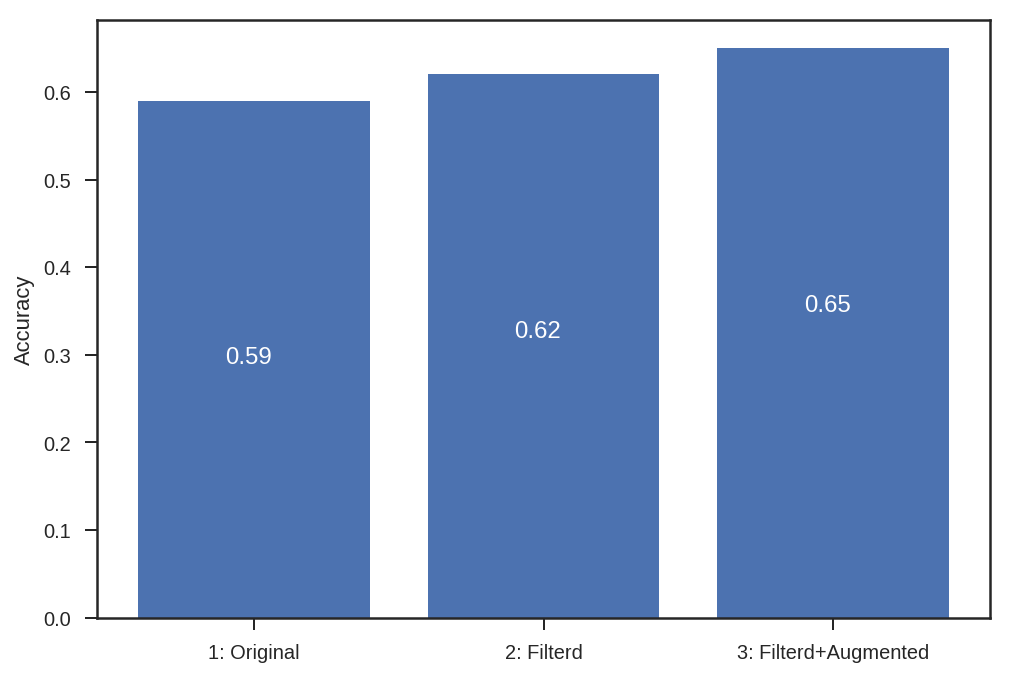

In [42]:
plt.bar(range(3), accs, tick_label=[param['name'] for param in params])
for i, acc in enumerate(accs):
    plt.text(i - 0.1, acc-0.3, str(acc), color='w')
plt.ylabel('Accuracy')

　ランダムに分類しても$acc=0.5$となるはずなので，微妙な結果となってしまいました…．しかし，FilterとAugmentationの効果が確認できたのは，不幸中の幸いです．
 
## 考察

　最も性能の良いモデル３（Filterd+Augmented）の結果をもう少し掘り下げます．

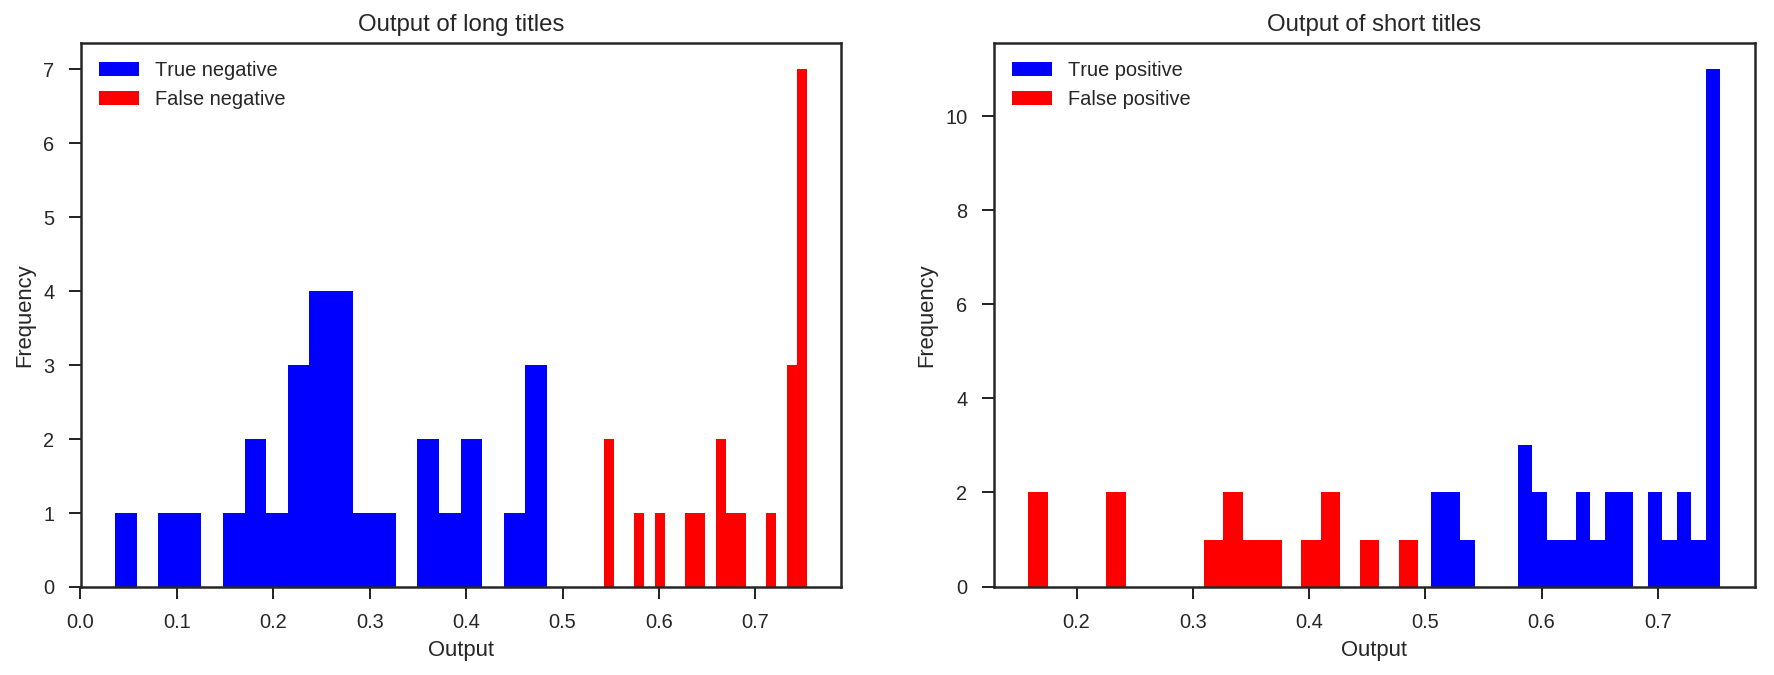

In [43]:
output = np.array(outputs[2])
output_long = output[wjnet.y_test.reshape((-1))==0]
output_short = output[wjnet.y_test.reshape((-1))==1]

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(output_long[output_long < 0.5], bins=20, 
         color='b', label='True negative')
plt.hist(output_long[output_long >= 0.5], bins=20, 
         color='r', label='False negative')
plt.ylabel('Frequency')
plt.xlabel('Output')
plt.title('Output of long titles')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(output_short[output_short >= 0.5], bins=20, 
         color='b', label='True positive')
plt.hist(output_short[output_short < 0.5], bins=20, 
         color='r', label='False positive')
plt.ylabel('Frequency')
plt.xlabel('Output')
plt.title('Output of short titles')
plt.legend()

特に気になるのが，False positive（つまり，実際は短命作品なのに，継続作品と分類

In [44]:
len(wj.end_titles)

592

In [45]:
len(wjnet.y_test) + len(wjnet.y_val) + len(wjnet.y_tra)

546

以下，記事の下書き．ある程度性能がでるようになったら，記事として清書しよう．少し冗長すぎる気がするので，的を絞って記述しよう．

　以下では，簡単に`ComicNet`を解説します．TensorFlowの考え方については，[TensorFlowのキーコンセプト: Opノード、セッション、変数](http://qiita.com/yanosen_jp/items/70e6d6afc36e1c0a3ef3)が詳しいです．

### データの生成：`get_x()`，`get_y()`，`get_xs_ys()`

　`get_x()`は，0から1の間に正規化された掲載順を返します．`get_y()`は，短命作品か（`1`）否か（`0`）を返します．`get_xs_ys()`は，内部で`get_x()`および`get_y()`を呼び出し，複数タイトルの`x`および`y`を返します．
 
　`ComicNet`は初期化時に，trainingデータ（`x_tra`，`y_tra`），validationデータ（`x_val`，`y_val`），およびtestデータ（`x_test`，`y_test`）を生成します．trainingデータは，文字通りモデルの学習に用いるデータです．検証用データは，モデルの汎化性能を一時的に評価するため（trainingデータへの過学習を防ぐため）のデータであり，ハイパーパラメータの調整時に利用します．testデータは，ハイパーパラメータ調整後のモデルの性能を評価するためのデータです．これらについては，[なぜ教師あり学習でバリデーションセットとテストセットを分ける必要があるのか？](http://qiita.com/QUANON/items/ae569961ea02b4468e23)がわかりやすいです．今回は，`wj.end_titles`のうち，最新100件をtestデータ，残りの最新`batch_size`件をvalidationデータ，残りをtrainデータとして用います．

### データグラフの構築：`build_graph()`

　入力層では，`tf.placeholder`で入力テンソル（`x`）や教師ラベルテンソル（`y`）をを定義します．
 
　隠れ層では，`tf.Variable`で重みテンソル（`w_h_1`，`w_h_2`，`w_h_3`）やバイアス（`b_h_1`，`b_h_2`，`b_h_3`）を定義します．ここでは，`Variable`の初期分布として[`tf.truncated_normal`](https://www.tensorflow.org/api_docs/python/tf/truncated_normal)を与えています．`truncated_normal`は，2シグマより外の値を除外した正規分布であり，好んでよく使われます．実は，この`truncated_normal`の標準偏差は，モデルの性能を左右する重要なハイパーパラメータの一つですが，今回は簡単のため`0.05`に固定します．[`tf.add`](https://www.tensorflow.org/api_docs/python/tf/add)，[`tf.matmul`](https://www.tensorflow.org/api_docs/python/tf/matmul)，[`tf.nn.relu`](https://www.tensorflow.org/api_docs/python/tf/nn/relu)を使って，テンソル同士を結合し，隠れ層を形作っていきます．ちなみに，[`tf.nn.relu`](https://www.tensorflow.org/api_docs/python/tf/nn/relu)を[`tf.nn.sigmoid`](https://www.tensorflow.org/api_docs/python/tf/sigmoid#tfnnsigmoid)に書き換れば，活性化関数として[Sigmoid](https://ja.wikipedia.org/wiki/%E6%B4%BB%E6%80%A7%E5%8C%96%E9%96%A2%E6%95%B0#.E3.82.B7.E3.82.B0.E3.83.A2.E3.82.A4.E3.83.89.E9.96.A2.E6.95.B0)を使うことができます．TensorFlowで使用可能な活性化関数については，[こちら](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn/activation_functions_)をご参照ください．[`tf.summary.histgram`](https://www.tensorflow.org/api_docs/python/tf/summary/histogram)に`tf.Variable`を渡すことで，TensorBoardでヒストグラムを確認できるようになります．
  
　出力層では，基本的に潜れ層と同様の処理を行います．損失関数[`tf.nn.sigmoid_cross_entropy_with_logits`](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits)の内部に活性化関数（sigmoid）を含むため，出力層では特に活性化関数を使う必要がないことにご注意ください．[`tf.summary.scalar`](https://www.tensorflow.org/api_docs/python/tf/summary/scalar)に`tf.Variable`を渡すことで，TensorBoardで時変化を確認できるようになります．
 
　最適化アルゴリズムとして，[`tf.train.AdamOptimizer`](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer)を使います．TensorFlowで使用可能な最適化アルゴリズムについては，[こちら](https://www.tensorflow.org/versions/r0.12/api_docs/python/train/)をご参照ください．最終的な出力値`logits`を四捨五入し（つまり閾値0.5で判定し），教師ラベル`y`に対する正解率を`acc`として計算しています．最後に，全ての[`tf.summary.merge_all`](https://www.tensorflow.org/api_docs/python/tf/summary/merge_all)で全てのログ情報をマージします．

### 学習：`train()`

　TensorFlowでは，[`tf.Session`](https://www.tensorflow.org/api_docs/python/tf/Session)中で学習を行います．必ず，[`tf.global_variables_initializer()`](https://www.tensorflow.org/api_docs/python/tf/global_variables_initializer)で`Variable`の初期化を行う必要があります（これがないと怒られます）．
 
 　`sess.run(self.optimizer)`によって，モデルを学習します．`sess.run`の第一引数は，タプルによって複数指定することが可能です．また，`sess.run()`時に，辞書形式で`placeholder`に値を代入する必要があります．Training時は`x_tra_batch`と`x_tra_batch`を代入し，Validation時は`x_val`と`y_val`を代入します．

　[`tf.summary.FileWriter`](https://www.tensorflow.org/api_docs/python/tf/summary/FileWriter)で，TensorBoard用のログ情報を保存できます．また，[`tf.train.Saver`](https://www.tensorflow.org/api_docs/python/tf/train/Saver)で学習後のモデルを保存できます．

### テスト：`test()`

　`test()`は，学習済みの多層パーセプトロンをテストするメンバ関数です．[`tf.train.import_meta_graph`](https://www.tensorflow.org/api_docs/python/tf/train/import_meta_graph)を使って，学習済みのモデルを読み込みます．testデータ（`x_test`，`y_test`）を`feed_dict`に与え，`sess.run`します．

## 実験1.  短命作品（10週以内）の予測

　当初の目的である短命作品（10週以内）の予測に挑戦します．

### ハイパーパラメータの調整
　[TensorBoard](https://www.tensorflow.org/get_started/summaries_and_tensorboard)を使ってハイパーパラメータ（隠れ層のノード数$n$と，学習率$r$）をチューニングします．TensorBoardの詳細は[公式](https://www.tensorflow.org/get_started/summaries_and_tensorboard)をご参照ください．いろいろ遊べますが，本記事では，validationデータの正解率と損失関数を可視化することで，ハイパーパラメータの調整を行います．

In [11]:
for model in range(1, 8):
    wjnet = ComicNet(wj, model=model)
    for r in [0.1, 0.05, 0.01, 0.005, 0.001]:
        for n in range(1, 8):
            log_dir = './logs/1/model=' + str(model)
            log_name = 'r={},n={}'.format(str(r), str(n))
            wjnet.build_graph(r=r, n_h=n)
            wjnet.train(save_log=True, log_dir=log_dir, log_name=log_name)
            print('Saved log of model={}, r={}, n={}'.\
                  format(str(model), str(r), str(n)))

Saved log of model=1, r=0.1, n=1
Saved log of model=1, r=0.1, n=2
Saved log of model=1, r=0.1, n=3
Saved log of model=1, r=0.1, n=4
Saved log of model=1, r=0.1, n=5
Saved log of model=1, r=0.1, n=6
Saved log of model=1, r=0.1, n=7
Saved log of model=1, r=0.05, n=1
Saved log of model=1, r=0.05, n=2
Saved log of model=1, r=0.05, n=3
Saved log of model=1, r=0.05, n=4
Saved log of model=1, r=0.05, n=5
Saved log of model=1, r=0.05, n=6
Saved log of model=1, r=0.05, n=7
Saved log of model=1, r=0.01, n=1
Saved log of model=1, r=0.01, n=2
Saved log of model=1, r=0.01, n=3
Saved log of model=1, r=0.01, n=4
Saved log of model=1, r=0.01, n=5
Saved log of model=1, r=0.01, n=6
Saved log of model=1, r=0.01, n=7
Saved log of model=1, r=0.005, n=1
Saved log of model=1, r=0.005, n=2
Saved log of model=1, r=0.005, n=3
Saved log of model=1, r=0.005, n=4
Saved log of model=1, r=0.005, n=5
Saved log of model=1, r=0.005, n=6
Saved log of model=1, r=0.005, n=7
Saved log of model=1, r=0.001, n=1
Saved log of 

KeyboardInterrupt: 

【タスク】以下，修正すること！

TensorBoardを起動します．ここでは，`model=7`のvalidation結果を見てみます．
 
```bash
tensorboard --logdir=./logs/1/model=7/val
```

　指定されたURLをブラウザで開きます．

![tensorboard.png](fig/tensorboard.png)

　上図はvalidationデータの正解率（`acc`），下図はvalidationデータの損失関数（`loss`）を表します．横軸はエポック数を表します．凡例が多すぎてわけがわからないので，左下の`Runs`でフィルタリングします．下図は，`n=7`でフィルタリングした例です．

![scalar,n=7.png](fig/scalar,n=7.png)

　`r=0.001`がいい感じであることがわかります．次は，`r=0.001`でフィルタリングします．

![scalar,r=0.001.png](fig/scalar,r=0.001.png)

　どうやら，`model=7`に関しては，`n=7, r=0.001`が良さそうです．また，`e=5000`あたりからtrainingデータへの過学習が始まり，正解率と損失関数が悪化していることがなんとなくわかります．そこで，`model=7`に関しては，学習を5000エポックで打ち切ることにします．
 
　上記の作業を，他のモデル（`model=1, 2,..., 6`）に関しても行い，ハイパーパラメータを最適化します．
 
 |model | $r$ | $n$ | epoch |
 |:--:|:--|:--|:--|
 

### 学習

　最適化したハイパーパラメータで，再度学習を行い，モデルを保存します．

In [52]:
!mkdir models

In [53]:
params = [
#    [1, 0.001, 1, 5000], [2, 0.05, 3, 5000], [3, 0.001, 5, 2000],
#    [4, 0.005, 7, 5000], [5, 0.01, 7, 5000], [6, 0.001, 7, 3000], 
#    [7, 0.001, 7, 5000]
]

for param in params:
    model = param[0]
    r = param[1]
    n = param[2]
    epoch = param[3]
    model_path = './models/model{}_thesh10'.format(str(model))
    
    wjnet = ComicNet(wj, model=model)
    wjnet.build_graph(r=r, n_h=n)
    wjnet.train(save_model=True, model_path=model_path, epoch=epoch)
    print('Trained', model_path)

Trained ./models/model1_thesh10
Trained ./models/model2_thesh10
Trained ./models/model3_thesh10
Trained ./models/model4_thesh10
Trained ./models/model5_thesh10
Trained ./models/model6_thesh10
Trained ./models/model7_thesh10


### テスト

　testデータで，性能を評価します．

In [54]:
result_thresh10 = {}
for param in params:
    model = param[0]
    r = param[1]
    n = param[2]
    model_path = './models/model{}_thesh10'.format(str(model))

    wjnet = ComicNet(wj, model=model)
    wjnet.build_graph(r=r, n_h=n)
    result_thresh10[model] = wjnet.test(model_path=model_path)
    print('Tested', model_path, 'acc: ', 
          str(result_thresh10[model][0]))

Tested ./models/model1_thesh10 acc:  0.95
Tested ./models/model2_thesh10 acc:  0.95
Tested ./models/model3_thesh10 acc:  0.95
Tested ./models/model4_thesh10 acc:  0.95
Tested ./models/model5_thesh10 acc:  0.95
Tested ./models/model6_thesh10 acc:  0.95
Tested ./models/model7_thesh10 acc:  0.91


　正解率95%！しかし，何か怪しい…．

### 考察

　やけに結果が良いので，testデータの出力値をヒストグラムで分析します．

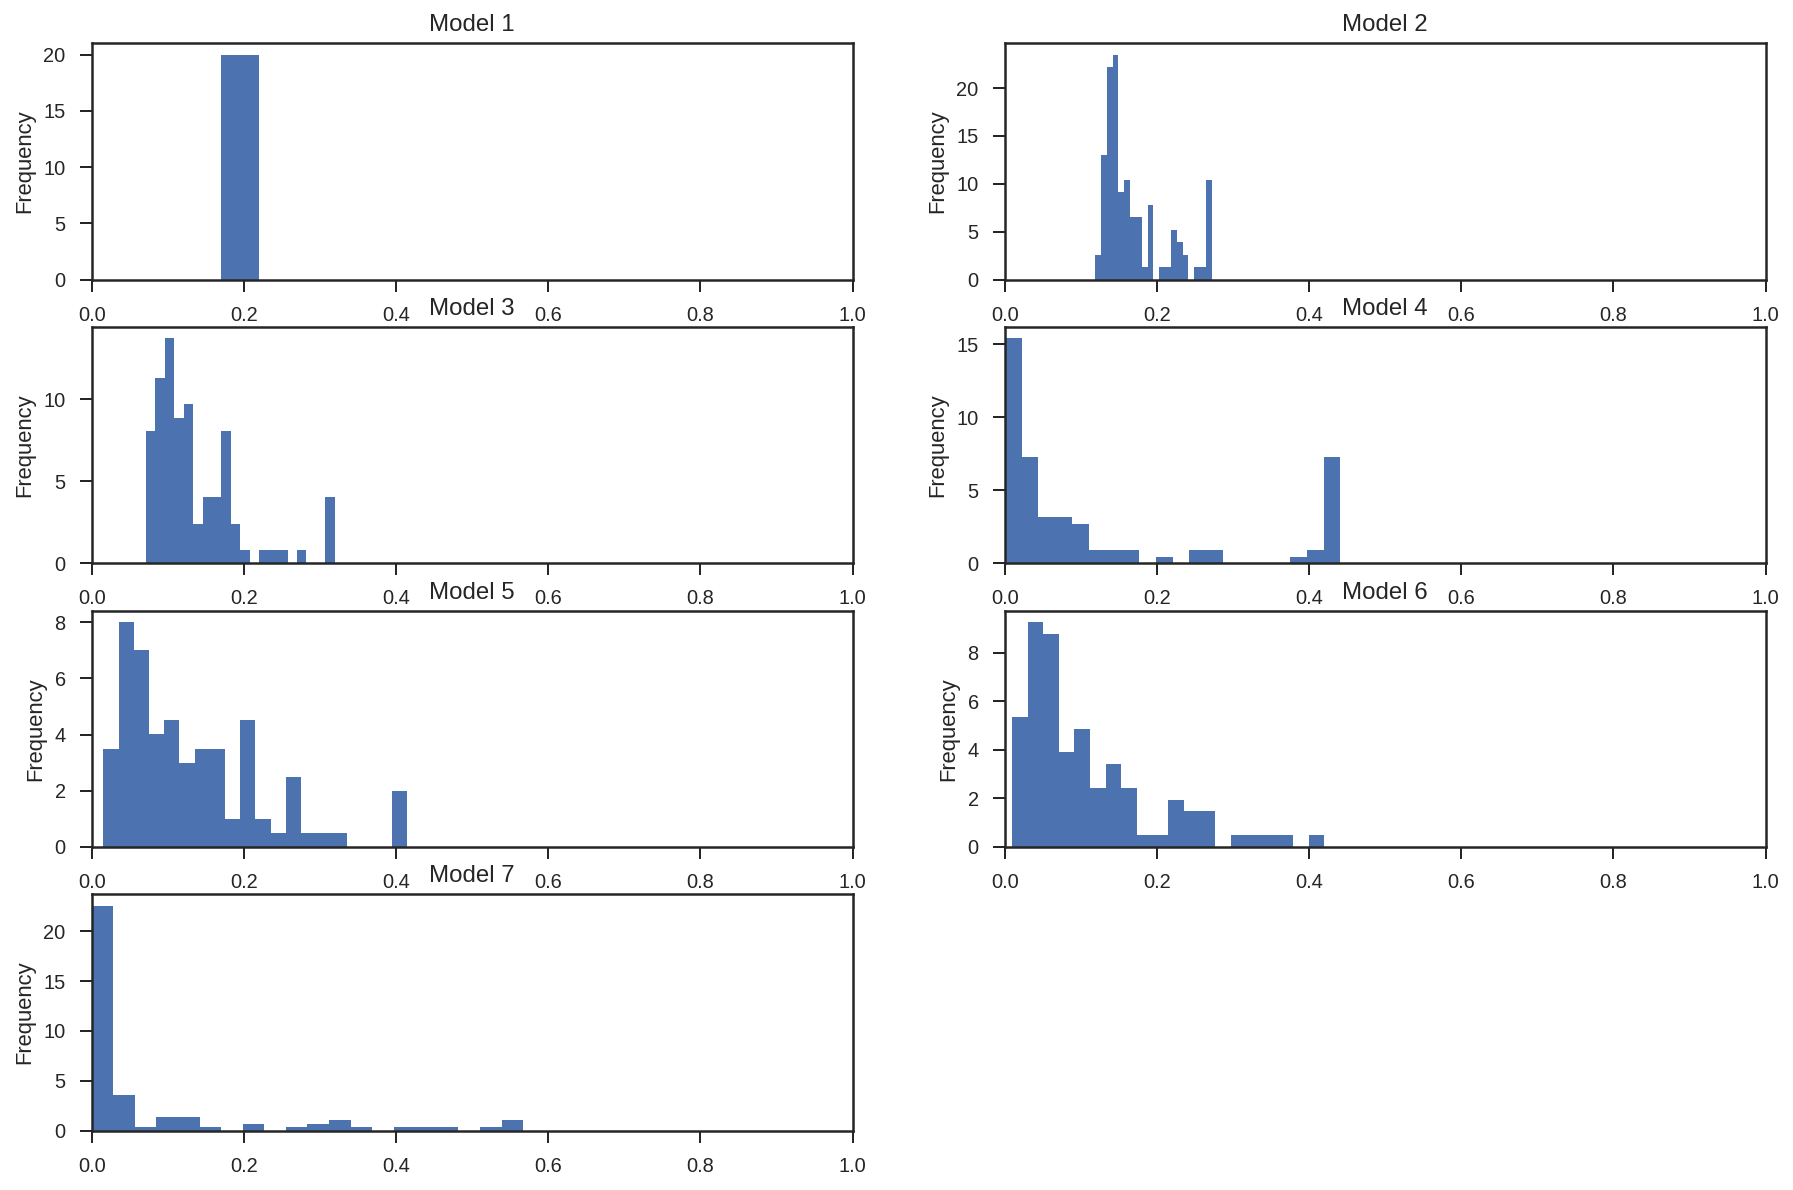

In [55]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

for model in range(1, 8):
    logits = result_thresh10[model][1]
    
    plt.subplot(4, 2, model)
    plt.hist(logits, bins=20, normed=True)
    plt.ylabel('Frequency')
    plt.xlim(0,1)
    plt.title('Model {}'.format(model))

　横軸はtestデータの出力値，縦軸は度数を表します．出力値が0.5以上の作品は短命作品と判断されます．図から，Model 7以外は，全てのtestデータに対して「短命作品ではない」と判断していることがわかります．これは，そもそもtrainingデータ中に短命作品が稀なため，「とりあえず短命作品と判断しない方が得策」という方向に学習が進んだ結果と思われます．実際，testデータは5件しか短命作品を含まないため，この戦略は正しいです．しかし，全く面白くない結果です．

In [45]:
(wjnet.y_test == 1).sum()

5

　そこで，全作品の掲載週の分布を確認し，より多くの作品を含むように（識別問題として面白くなるように），短命作品の定義を変更します．

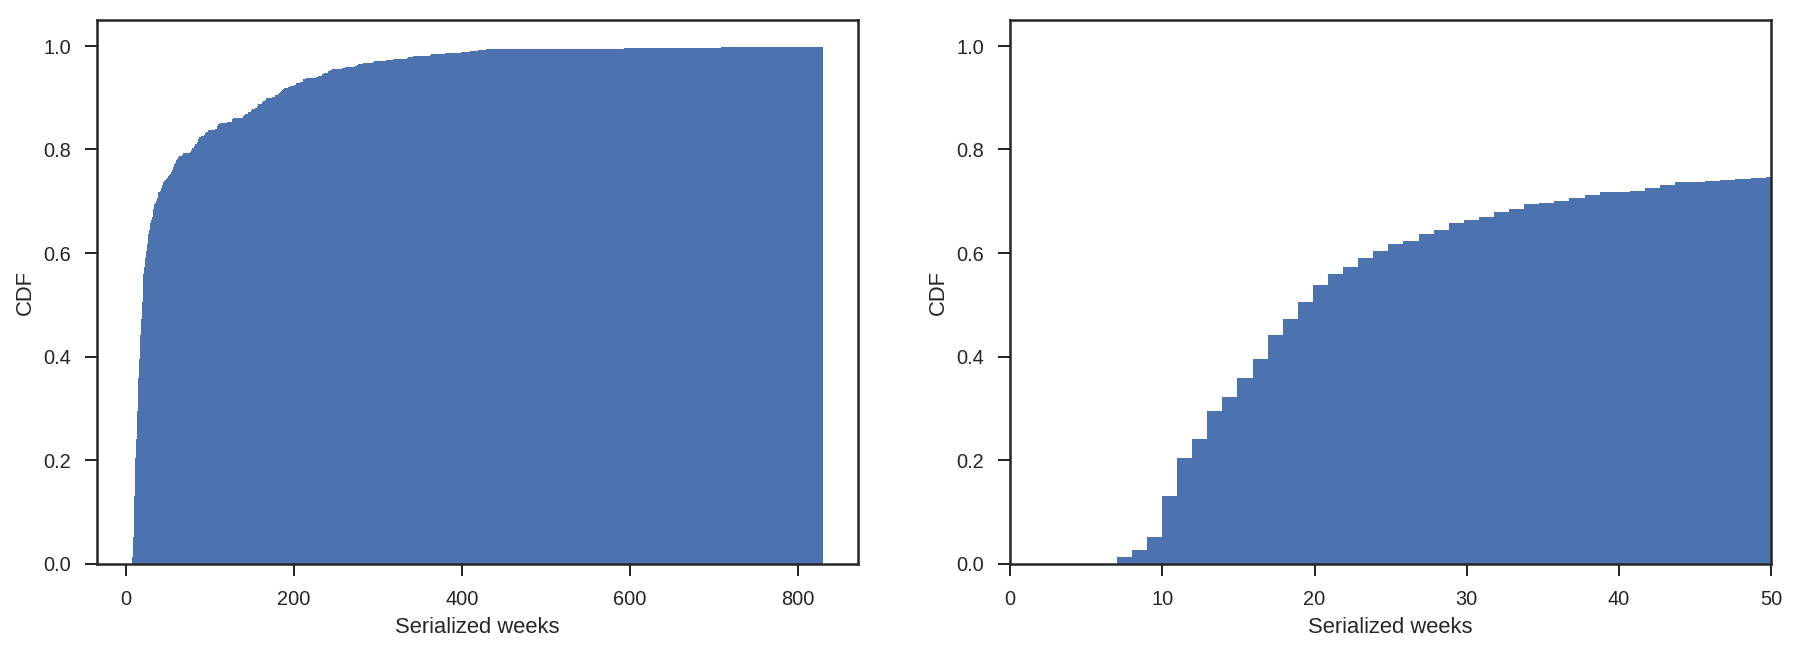

In [50]:
import numpy as np

weeks = [len(wj.extract_item(title))
         for title in wj.end_titles]

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
_ = plt.hist(weeks, normed=True, cumulative=True, bins=max(weeks))
plt.xlabel('Serialized weeks')
plt.ylabel('CDF')

plt.subplot(1, 2, 2)
_ = plt.hist(weeks, normed=True, cumulative=True, bins=max(weeks))
plt.xlim(0, 50)
plt.xlabel('Serialized weeks')
plt.ylabel('CDF')

　どうやら，約半分の作品が20週以内に掲載を終えるようです．よって，以下では短命作品（20週以内）の予測に挑戦します．

## 実験2. 短命作品（20週以内）の予測

　`ComicNet()`の引数で`thresh_week=20`を指定する以外は，上記の実験と全く同じ手順を踏みます．

### ハイパーパラメータの調整

【タスク】
全然思ったように学習してくれない．原因もよくわからないし．レイヤ数を少なくしたり，活性化関数を変えたり，試行錯誤中．

　TensorBoardで分析すると，以下のハイパーパラメータを得られます．詳細は割愛します．
 
 |model | $r$ | $n$ | epoch |
 |:--|:--|:--|:--|


### 学習

### テスト

### 考察

## 実験3. 架空のマンガ作品の打切予測

## タスク（2017/5/21）

* `ComicNet()`のメンバ関数に，データ生成用の関数も含めること．`ComicNet()`には，何も考えずにComicAnalizer()`の結果を突っ込めるようにしたい．
* `ComicNet()`の引数に，`threash_week`を追加すること．
* `ComicNet()`の引数に，`save`を追加すること．これは，学習結果を保存するか否かを表すフラグ．
* 最終的には，10週終了，20週終了，30週終了の予測結果をまとめてひとつのグラフにすること．
* 考察では，大きく外れた例を一つか２つ掲載すること．
* `ComicEndPredictor()`というクラスを生成すること．これは，学習済みデータをそのまま使って，終了予測を行うことができるクラス．つまり，githubには学習済みクラスのsavarデータをアップする必要がある．